# Object classification with APOC and SimpleITK-based features

Classifying objects can involve extracting custom features. We simulate this scenario by using [SimpleITK-based](https://simpleitk.readthedocs.io/) features as available in [napari-simpleitk-image-processing](https://www.napari-hub.org/plugins/napari-simpleitk-image-processing) and train an APOC [table-row-classifier](https://nbviewer.org/github/haesleinhuepf/apoc/blob/main/demo/table_row_classification.ipynb).

See also
* [Machine learning for pixel and bbject classification (video lecture)](https://www.youtube.com/watch?v=dstjhCPBDOY&list=PL5ESQNfM5lc7SAMstEu082ivW4BDMvd0U&index=19)

In [1]:
from skimage.io import imread
import pyclesperanto_prototype as cle
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from napari_simpleitk_image_processing import label_statistics
import apoc
import stackview

Our starting point are an image, a label image and some ground truth annotation. The annotation is also a label image where the user was just drawing lines with different intensity (class) through small objects, large objects and elongated objects.

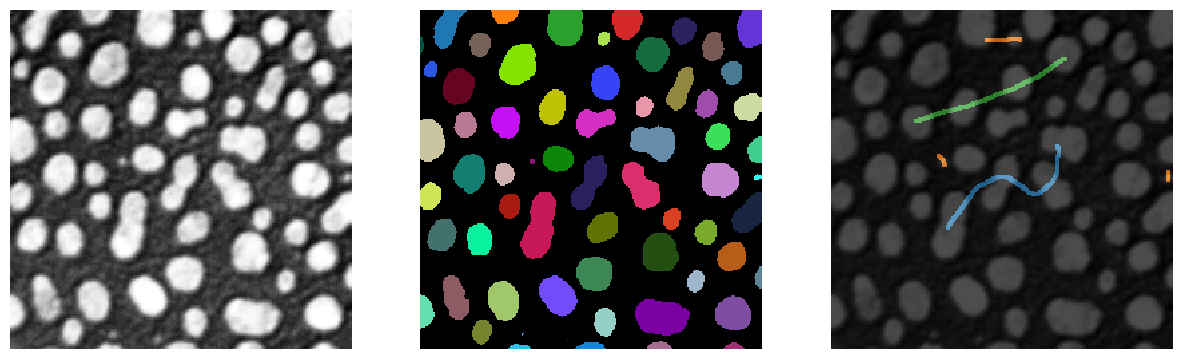

In [2]:
# load and label data
image = imread('data/blobs.tif')
labels = label(image > threshold_otsu(image))
annotation = imread('data/blobs_label_annotation.tif')

# visualize
fig, ax = plt.subplots(1,3, figsize=(15,15))
stackview.imshow(image, plot=ax[0])
stackview.imshow(labels, plot=ax[1], labels=True)
stackview.imshow(image, plot=ax[2], continue_drawing=True)
stackview.imshow(annotation, plot=ax[2], alpha=0.7, labels=True)

## Feature extraction
The first step to classify objects according to their properties is [feature extraction](feature_extraction). We will use the scriptable napari plugin [napari-simpleitk-image-processing](https://www.napari-hub.org/plugins/napari-simpleitk-image-processing) for that.

In [3]:
statistics = label_statistics(image, labels, size=True, intensity=True, shape=True)

statistics_table = pd.DataFrame(statistics)
statistics_table.head(5)

,label,maximum,mean,median,minimum,sigma,sum,variance,elongation,feret_diameter,flatness,roundness,equivalent_ellipsoid_diameter_0,equivalent_ellipsoid_diameter_1,equivalent_spherical_perimeter,equivalent_spherical_radius,number_of_pixels,number_of_pixels_on_border
0,1,232.0,190.854503,200.0,128.0,30.304925,82640.0,918.388504,2.078439,35.227830,2.078439,0.0,16.286596,33.850704,73.764751,11.740025,433,17
1,2,224.0,179.286486,184.0,128.0,21.883314,33168.0,478.879436,1.784283,20.223748,1.784283,0.0,11.489710,20.500894,48.215958,7.673808,185,21
2,3,248.0,205.617021,208.0,128.0,29.380812,135296.0,863.232099,1.068402,31.622777,1.068402,0.0,28.002749,29.918192,90.932238,14.472315,658,23
3,4,248.0,217.327189,232.0,128.0,36.061134,94320.0,1300.405402,1.063793,25.806976,1.063793,0.0,22.791422,24.245348,73.849880,11.753574,434,19
4,5,248.0,212.142558,224.0,128.0,29.904270,101192.0,894.265349,1.571246,30.463092,1.571246,0.0,19.660392,30.891311,77.421953,12.322086,477,39


In [4]:
statistics_table.columns

Index(['label', 'maximum', 'mean', 'median', 'minimum', 'sigma', 'sum',
       'variance', 'elongation', 'feret_diameter', 'flatness', 'roundness',
       'equivalent_ellipsoid_diameter_0', 'equivalent_ellipsoid_diameter_1',
       'equivalent_spherical_perimeter', 'equivalent_spherical_radius',
       'number_of_pixels', 'number_of_pixels_on_border'],
      dtype='object')

In [5]:
table = statistics_table[['number_of_pixels','elongation']]
table

,number_of_pixels,elongation
0,433,2.078439
1,185,1.784283
2,658,1.068402
3,434,1.063793
4,477,1.571246
...,...,...
59,1,0.000000
60,81,3.134500
61,90,4.182889
62,53,2.923862


We also read out the maximum intensity of every labeled object from the ground truth annotation. These values will serve to train the classifier. Entries of `0` correspond to objects that have not been annotated.

In [6]:
annotation_stats = regionprops(labels, intensity_image=annotation)

annotated_classes = np.asarray([s.max_intensity for s in annotation_stats])
print(annotated_classes)

[0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 3. 0. 0. 0. 3. 0. 0. 3. 0. 0. 0. 3. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 2. 1. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Classifier Training
Next, we can train the Random Forest Classifer. It needs tablue training data and a ground truth vector.

In [7]:
classifier_filename = 'data/table_row_classifier.cl'

table_classifier = apoc.TableRowClassifier(opencl_filename=classifier_filename, max_depth=2, num_ensembles=10)
table_classifier.train(table, annotated_classes)
table_classifier

Classifier type: TableRowClassifier
--- Random forest info ---
Used features for training: number_of_pixels elongation
Ground truth dimensions: 1
Maximum depth: 2
Number of ensembles: 10
Number of classes: 3
Number of features: 2
Number of channels: 1

## Prediction
To apply a classifier to the whole dataset, or any other dataset, we need to make sure that the data is in the same format. This is trivial in case we analyse the same dataset we trained on.

In [8]:
predicted_classes = table_classifier.predict(table)
predicted_classes

array([1, 1, 2, 3, 3, 3, 2, 3, 2, 1, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 3,
       1, 3, 3, 3, 3, 1, 3, 3, 1, 2, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3, 3, 2,
       3, 2, 3, 2, 1, 3, 1, 3, 3, 1, 3, 3, 3, 2, 1, 2, 1, 1, 1, 1],
      dtype=uint32)

For documentation purposes, we can save the annotated class and the predicted class into the our table. Note: We're doing this after training, because otherwise e.g. the column

In [9]:
table

,number_of_pixels,elongation
0,433,2.078439
1,185,1.784283
2,658,1.068402
3,434,1.063793
4,477,1.571246
...,...,...
59,1,0.000000
60,81,3.134500
61,90,4.182889
62,53,2.923862


In [10]:
table['annotated_class'] = annotated_classes
table['predicted_class'] = predicted_classes
table

C:\Users\haase\AppData\Local\Temp\ipykernel_20616\2818530951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['annotated_class'] = annotated_classes
C:\Users\haase\AppData\Local\Temp\ipykernel_20616\2818530951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['predicted_class'] = predicted_classes


,number_of_pixels,elongation,annotated_class,predicted_class
0,433,2.078439,0.0,1
1,185,1.784283,0.0,1
2,658,1.068402,2.0,2
3,434,1.063793,0.0,3
4,477,1.571246,0.0,3
...,...,...,...,...
59,1,0.000000,0.0,2
60,81,3.134500,0.0,1
61,90,4.182889,0.0,1
62,53,2.923862,0.0,1


Furthermore, we can use the same vector to use [`replace_intensities`](https://clij.github.io/clij2-docs/reference_replaceIntensities) to generate a `class_image`. The background and objects with NaNs in measurements will have value 0 in that image.

In [11]:
# we add a 0 for the class of background at the beginning
predicted_classes_with_background = [0] + predicted_classes.tolist()
print(predicted_classes_with_background)

[0, 1, 1, 2, 3, 3, 3, 2, 3, 2, 1, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 2, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3, 3, 2, 3, 2, 3, 2, 1, 3, 1, 3, 3, 1, 3, 3, 3, 2, 1, 2, 1, 1, 1, 1]


StackViewNDArray([[0, 0, 0, ..., 3, 3, 3],
                  [0, 0, 0, ..., 3, 3, 3],
                  [0, 0, 0, ..., 3, 3, 3],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
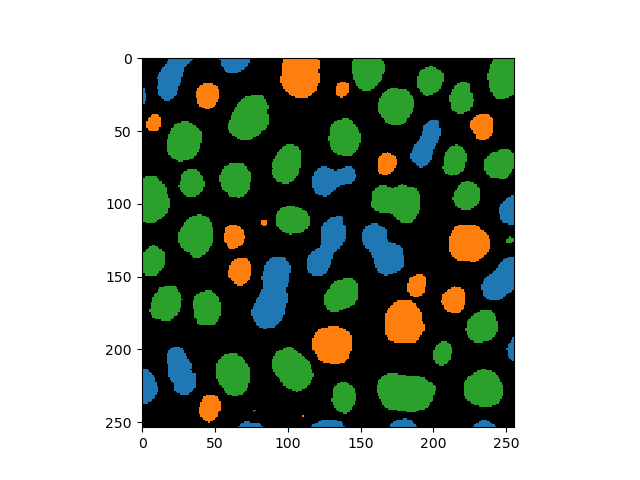

In [12]:
class_image = cle.replace_intensities(labels, predicted_classes_with_background).astype(np.uint32)
stackview.insight(class_image)

## Exercise
Do the object classification again, but with measurements from [scikit-image's regionprops_table](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table).